# Titanic Survival Prediction

Author: Rosa Pham

### Table of Contents
- Introduction
- Exploratory Data Analysis
    -   Data checking
    -   Explore features
- Data Processing
- Feature Selection
- Predictive Models
    -   Random Forest Classifier
    -   Gradient Boosted Classifier
    -   Logistic Regresion
- Models Comparision
- Applying the best model for the testing dataset
- Conclusion
    

## 1. Introduction

The sinking of the Titanic is one of the most renowned disasters in history. The Titanic, a British passenger ship operated by the White Star Line, sank in the North Atlantic Ocean on April 15, 1912, after striking an iceberg during its voyage from Southampton to New York City.

Primary Objectives:
- Conduct a statistical analysis to determine how certain groups had higher survival rates.
- Perform an exploratory data analysis (EDA) of the Titanic dataset, incorporating visualizations and storytelling.
- Apply supervised machine learning methods using PySpark to predict passenger survival and identify the most accurate model.

Dataset:

The training data comprises 891 instances, with 12 columns: 11 columns are predictors while the last column is label.

| Feature Name | Description |
| --- | --- |
| PassengerId | Identity of the passenger |
| Survived | Whether the passenger survived or not - 0 (No) - 1 (Yes) |
| Pclass | Class of the ticket holder (1, 2, 3) |
| Name | Name of the passenger |
| Sex | Gender of the passenger |
| Age | Age of the passenger |
| SibSp | Siblings and/or spouse travelling with passenger |
| Parch | Parents and/or children travelling with passenger |
| Ticket | Ticket number |
| Fare | Price of the ticket |
| Cabin | Cabin number |
| Embarked | Port of Embarkation: C (Cherbourg) - S (Southampton) - Q (Queenstown) |

## 2. Exploratory Data Analysis

In this section, we conduct a thorough investigation of data analysis on the given dataset. The analysis includes:
- Descriptive statistics to provide broad statistical insights and uncover patterns.
- Exploration of features through plots to understand their impact on the target variable.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import squarify
from sklearn.preprocessing import LabelEncoder
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel, TrainValidationSplit, TrainValidationSplitModel
from pyspark.ml.pipeline import Pipeline
from sklearn.metrics import confusion_matrix

In [2]:
spark = SparkSession.builder.appName("titanic_spark").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/25 07:48:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


#### 2.1 Data checking

In [3]:
train = spark.read.csv("./data/train.csv", header=True, inferSchema=True)
test = spark.read.csv("./data/test.csv", header=True, inferSchema=True)

##### -  Training dataset

Show the first 5 rows of the training dataset

In [4]:
train.show(5)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| NULL|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| NULL|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| NULL|       S|
+-----------+--------+------+--------------------+------+----+-----+-----+------

Check type of each column

In [5]:
train.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



24/05/25 07:48:30 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


Generate summary statistics for each attribute in the training dataset

In [6]:
train.describe().toPandas()

24/05/25 07:48:35 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,summary,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,count,891,891,891,891,891,714,891,891,891,891,204,889
1,mean,446.0,0.3838383838383838,2.308641975308642,None,None,29.69911764705882,0.5230078563411896,0.38159371492704824,260318.54916792738,32.2042079685746,None,None
2,stddev,257.3538420152301,0.48659245426485753,0.8360712409770491,None,None,14.526497332334035,1.1027434322934315,0.8060572211299488,471609.26868834975,49.69342859718089,None,None
3,min,1,0,1,"""Andersson, Mr. August Edvard (""""Wennerstrom"""")""",female,0.42,0,0,110152,0.0,A10,C
4,max,891,1,3,"van Melkebeke, Mr. Philemon",male,80.0,8,6,WE/P 5735,512.3292,T,S


Check the total number of observations in the training dataset

In [7]:
train.count()

891

Check the number of missing values in each column

In [8]:
train.select([f.count(f.when(f.isnan(c) | f.col(c).isNull(), c)).alias(c) for c in train.columns]).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,0,0,0,0,177,0,0,0,0,687,2


##### Summary of observations:
- The training dataset contains 891 observation.
- There are 177 missing values in Age column, 687 in Cabin column, 2 in Embarked colulmn.

##### - Testing dataset

Show the first 5 rows of the testing dataset

In [9]:
test.show(5)

+-----------+------+--------------------+------+----+-----+-----+-------+-------+-----+--------+
|PassengerId|Pclass|                Name|   Sex| Age|SibSp|Parch| Ticket|   Fare|Cabin|Embarked|
+-----------+------+--------------------+------+----+-----+-----+-------+-------+-----+--------+
|        892|     3|    Kelly, Mr. James|  male|34.5|    0|    0| 330911| 7.8292| NULL|       Q|
|        893|     3|Wilkes, Mrs. Jame...|female|47.0|    1|    0| 363272|    7.0| NULL|       S|
|        894|     2|Myles, Mr. Thomas...|  male|62.0|    0|    0| 240276| 9.6875| NULL|       Q|
|        895|     3|    Wirz, Mr. Albert|  male|27.0|    0|    0| 315154| 8.6625| NULL|       S|
|        896|     3|Hirvonen, Mrs. Al...|female|22.0|    1|    1|3101298|12.2875| NULL|       S|
+-----------+------+--------------------+------+----+-----+-----+-------+-------+-----+--------+
only showing top 5 rows



Check type of each column

In [10]:
test.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



Generate summary statistics for each attribute in the testing dataset

In [11]:
test.describe().toPandas()

,summary,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,count,418,418,418,418,332,418,418,418,417,91,418
1,mean,1100.5,2.2655502392344498,None,None,30.272590361445783,0.4473684210526316,0.3923444976076555,223850.98986486485,35.6271884892086,None,None
2,stddev,120.81045760473994,0.8418375519640503,None,None,14.181209235624424,0.8967595611217135,0.9814288785371694,369523.7764694362,55.907576179973844,None,None
3,min,892,1,"""Assaf Khalil, Mrs. Mariana (Miriam"""")""""""",female,0.17,0,0,110469,0.0,A11,C
4,max,1309,3,"van Billiard, Master. Walter John",male,76.0,8,9,W.E.P. 5734,512.3292,G6,S


Check the total number of observations in the testing dataset

In [12]:
test.count()

418

Check the number of missing values in each column

In [13]:
test.select([f.count(f.when(f.isnan(c) | f.col(c).isNull(), c)).alias(c) for c in test.columns]).toPandas()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,0,0,0,86,0,0,0,1,327,0


##### Summary of observations:
- The testing dataset contains 418 observation.
- There are 86 missing values in Age column, 327 in Cabin column, 1 in Fare colulmn.

#### 2.2 Explore features in the training dataset

In [14]:
# Set the global them for matplotlib and seaborn
df_train = train.toPandas()
sns.set_theme(rc={'axes.facecolor':'#dedad2', 'figure.facecolor':'#d7e1ee'})

##### - Feature 'Pclass'

In [15]:
# Show the percentage of each category in the feature
def percentage_with_hue(plot, feature, number_of_categories, hue_categories):
    patch = [p for p in plot.patches]
    ind = 0
    for i in range(number_of_categories):
        for j in range(hue_categories):
            x = patch[(j*number_of_categories + i)].get_x() + patch[(j*number_of_categories + i)].get_width() / 2 - 0.1
            y = patch[(j*number_of_categories + i)].get_y() + patch[(j*number_of_categories + i)].get_height()
            plot.annotate('{:.2f}%'.format(feature[ind]), (x, y), size = 10)
            ind += 1
    plt.show()

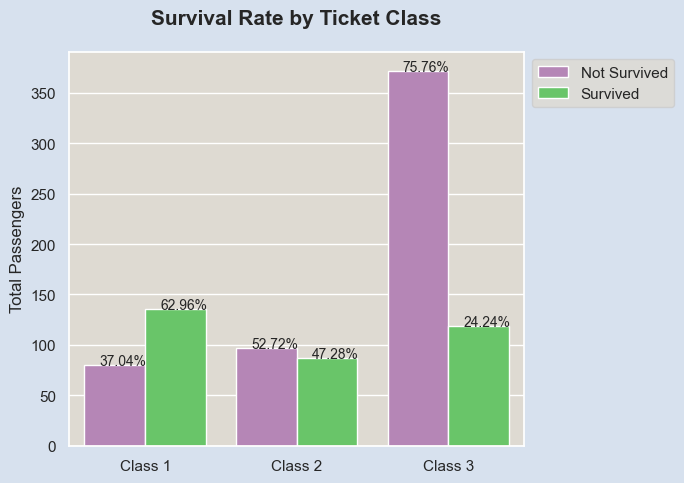

In [17]:
# Group Pclass and Survived features and calculate the percentage of each category
df_pclass = df_train.groupby(['Pclass', 'Survived']).size().reset_index()
df_pclass.rename(columns={0: 'Count'}, inplace=True)
df_pclass['Percentage'] = df_train.groupby(['Pclass', 'Survived']).size().groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).values
df_pclass['PclassLabel'] = np.where(df_pclass['Pclass'] == 1, 'Class 1', np.where(df_pclass['Pclass'] == 2, 'Class 2', 'Class 3'))
df_pclass['SurvivedLabel'] = np.where(df_pclass['Survived'] == 0, 'Not Survived', 'Survived')

# Plotting with Seaborn
plt.figure(figsize=(7, 5))
ax = sns.barplot(data=df_pclass, x='PclassLabel', y='Count', hue='SurvivedLabel', palette=["#bd7ebe", "#5ad45a"])
plt.title('Survival Rate by Ticket Class', fontsize=15, fontweight='bold', pad=20)
plt.legend(title='', loc='upper left')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel('')
plt.ylabel('Total Passengers')
plt.tight_layout()
percentage_with_hue(ax, df_pclass['Percentage'], 3, 2)

##### Summary
-   Class 3 had the highest number of passengers. It also indicated that the number of passengers died in Class 3 was significantly higher than other classes.
-   Class 1 had the highest number of survival passengers followed by Class 3 and Class 2.

##### - Features 'SibSp'

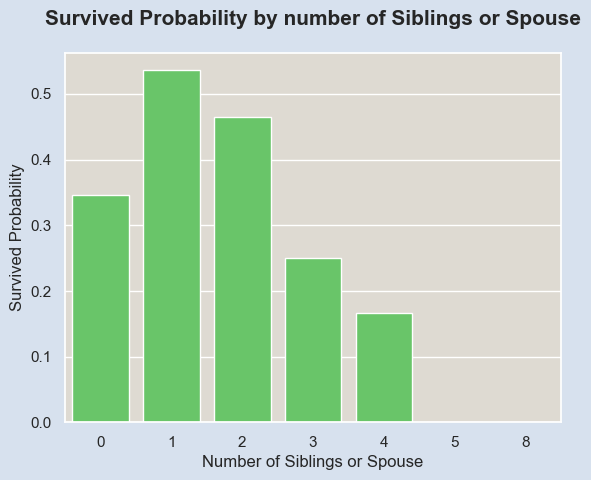

In [18]:
# Calculate survival rates
survival_rates = df_train.groupby('SibSp')['Survived'].mean().reset_index()

# Create bar plot using Seaborn
ax = sns.barplot(data=survival_rates, x='SibSp', y='Survived', color="#5ad45a")
plt.title("Survived Probability by number of Siblings or Spouse", fontsize=15, fontweight='bold', pad=20)
plt.xlabel("Number of Siblings or Spouse")
plt.ylabel("Survived Probability")
# Show plot
plt.show()

##### Summary 
-   There was a maximum of 8 siblings and spouses traveled along with one of the passenger.
-   With passengers having one sibling or spouse, the survived probability was more than 50%.
-   Passengers traveling with 2 siblings or spouse had the survived probability nearly 50%.
-   The chances of survival dropped drastically if someone traveled with more than 2 siblings or spouse.

##### - Feature 'Parch'

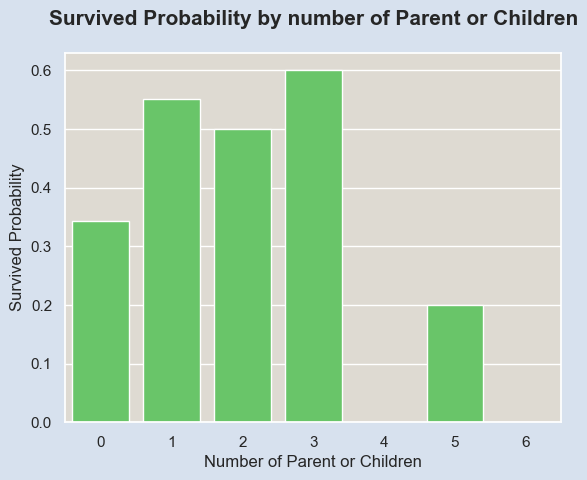

In [19]:
# Calculate survival rates
survival_rates = df_train.groupby('Parch')['Survived'].mean().reset_index()

# Create bar plot using Seaborn
sns.barplot(data=survival_rates, x='Parch', y='Survived', color="#5ad45a")
plt.title("Survived Probability by number of Parent or Children", fontsize=15, fontweight='bold', pad=20)
plt.xlabel("Number of Parent or Children")
plt.ylabel("Survived Probability")

# Show plot
plt.show()

##### Summary
-   Passengers traveled with 1 to 3 Parent or Children had the chance of survival more than 50%, especially with the highest probability for 3 Parent or Children at 60%.
-   With passenger traveled alone, the chance of survival was 34% while the survived probability for 5 Parent or Children was 20%.
-   There was no chance of survival for passengers traveled with 4 or 6 Parent or Children.

##### - Feature 'Fare'

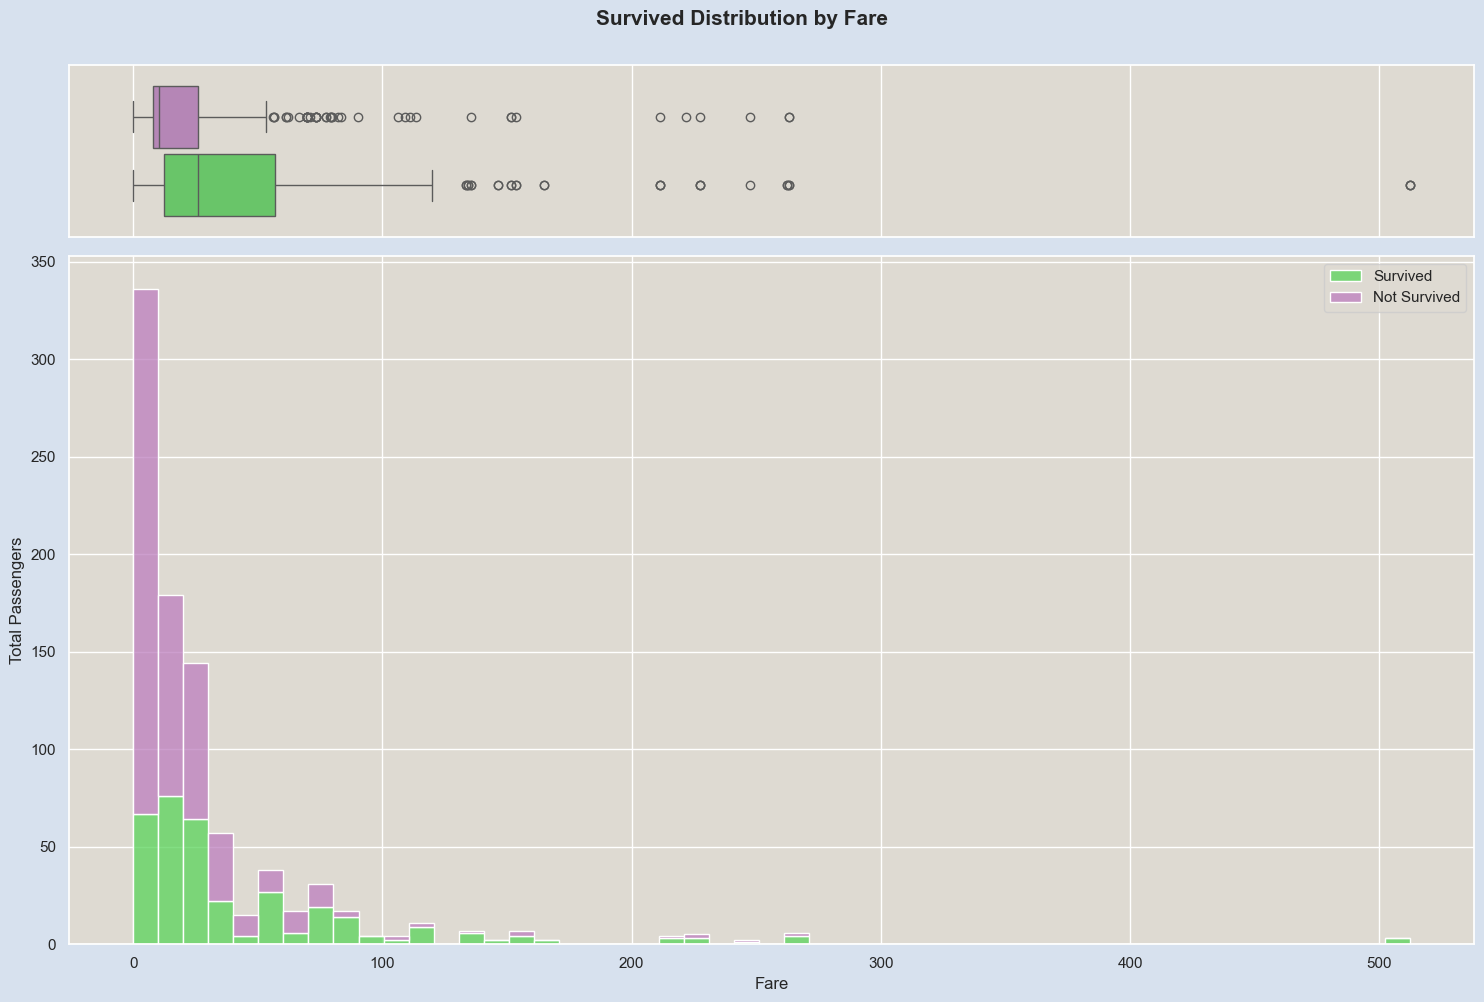

In [20]:
fig, (axbox, axhist) = plt.subplots(ncols=1, nrows=2, figsize=(15, 10), sharex=True, gridspec_kw={"height_ratios": (.2, .8)})
fig.suptitle('Survived Distribution by Fare', fontsize=15, fontweight='bold', y=1)

# Create boxplot
sns.boxplot(x='Fare', data=df_train, palette=["#bd7ebe", "#5ad45a"], hue='Survived', ax= axbox, gap=.1)

# Create histogram
ax = sns.histplot(data=df_train, x="Fare", hue="Survived", multiple="stack",
            palette=["#bd7ebe", "#5ad45a"], binwidth=10, ax=axhist)

plt.xlabel("Fare")
plt.ylabel("Total Passengers")
plt.legend(loc='upper right', labels=['Survived', 'Not Survived'])
ax.legend_.set_title(None)
axbox.legend_.remove()
fig.tight_layout()
plt.show()

##### Summary
-   There was a strong association between the fare and the survival.
-   The dispersion of survival for passengers paid more money was wider than the dispersion of death.
-   There were some outliers for passengers paid more money but still not survived.
-   The higher the passengers paid, the higher would be their chances to survive.

##### - Feature 'Age'

In [21]:
# Create age groups for better visualize the data
def modify_agegroup(age):
    if age <= 10:
        return "0-10"
    elif age <= 20 and age > 10:
        return "11-20"
    elif age <= 30 and age > 20:
        return "21-30"
    elif age <=40 and age > 30:
        return "31-40"
    elif age <= 50 and age > 40:
        return "41-50"
    elif age <= 60 and age > 50:
        return "51-60"
    elif age <= 70 and age > 60:
        return "61-70"
    elif age > 70:
        return "71+"

In [22]:
df_train['AgeGroup'] = df_train.apply(lambda x: modify_agegroup(x['Age']), axis=1)

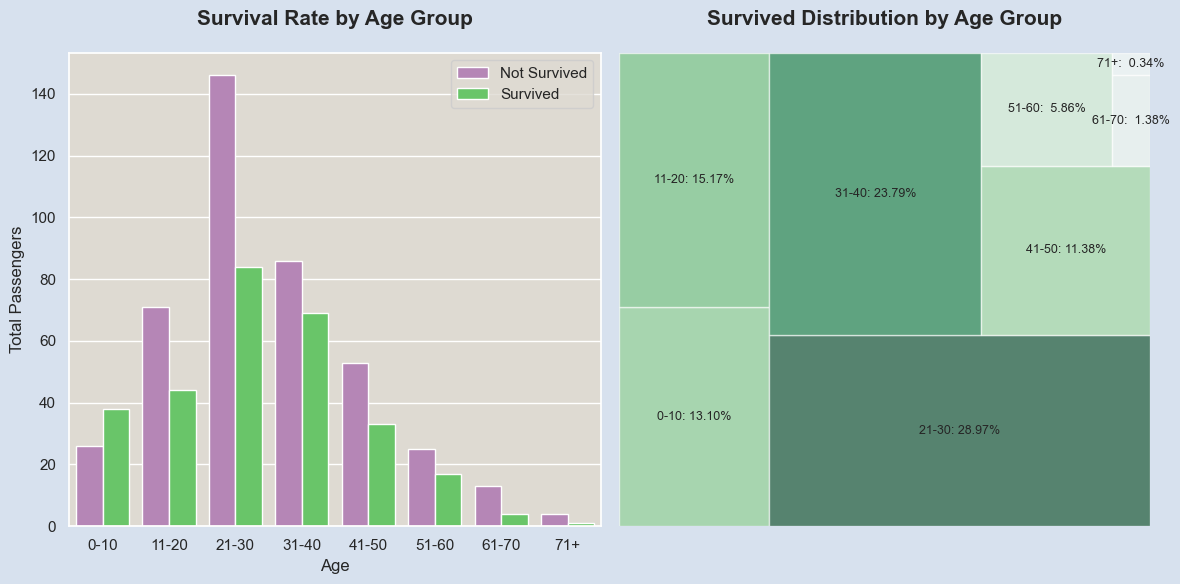

In [23]:
# Group by AgeGroup and Survived columns
df_age = df_train.groupby(['AgeGroup', 'Survived']).size().reset_index()
df_age.rename(columns={0: 'Count'}, inplace=True)

plt.figure(figsize=(12, 6))

# Create grouped barplot
plt.subplot(1, 2, 1)
labels_barplot = ['Not Survived', 'Survived']
ax = sns.barplot(data=df_age, x='AgeGroup', y='Count', hue='Survived', palette=["#bd7ebe", "#5ad45a"])
h, l = ax.get_legend_handles_labels()
ax.legend(h, labels_barplot, title='', loc='upper right')
plt.title('Survival Rate by Age Group', fontsize=15, fontweight='bold', pad=20)
plt.xlabel('Age')
plt.ylabel('Total Passengers')

# Create treemap
plt.subplot(1, 2, 2)
# Change relative colors based on the number of survived passengers
cmap = matplotlib.cm.Greens
mini=min(df_age[df_age['Survived'] == 1]['Count'])
maxi=max(df_age[df_age['Survived'] == 1]['Count'])
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in df_age[df_age['Survived'] == 1]['Count']]
# Display the percentage of survived passengers in each age group
perc_survived = [f'{i/df_age[df_age["Survived"] == 1]["Count"].sum()*100:5.2f}%' for i in df_age[df_age['Survived'] == 1]['Count']]
labels_treemap = [f'{df_age[df_age["Survived"] == 1]["AgeGroup"].iloc[i]}: {perc_survived[i]}' for i in range(len(df_age[df_age['Survived'] == 1]))]
squarify.plot(sizes=df_age[df_age['Survived'] == 1]['Count'], label=labels_treemap, 
              alpha=.6, color=colors, text_kwargs={'fontsize':9})
plt.title('Survived Distribution by Age Group', fontsize=15, fontweight='bold', pad=20)
plt.axis('off')

plt.tight_layout()
plt.show()

##### Summary
-   The chance of survival for passengers with age below 10 compared to not survival was significantly higher than other groups.
-   The most passengers onboard in between 21 to 40 year-old, and the chance of survival for these groups was nearly equal the death.
-   Based on the survived group, the age between 21 and 30 had the rate of survival higher than the other groups at 28.97%, and follow by the age between 31 and 40 at 23.79%.
-   With older passengers over 60 year olds, the chance of survival was low.

##### - Feature 'Sex'

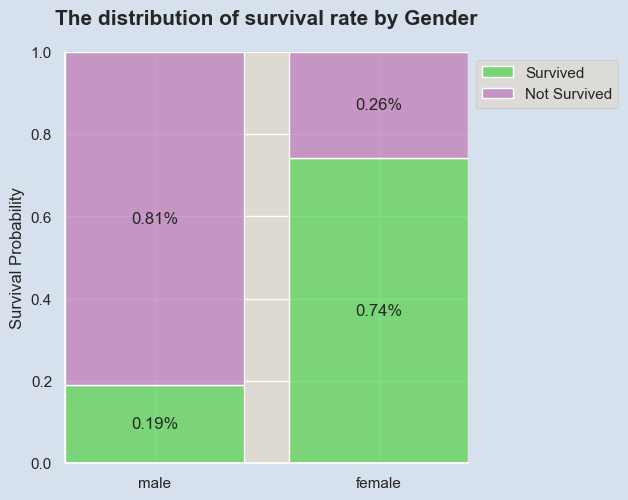

In [24]:
# Create grouped stacked barplot
g = sns.displot(df_train, x="Sex", hue="Survived", palette=["#bd7ebe", "#5ad45a"], stat="probability", multiple="fill", shrink=.8)
ax = g.axes.flat[0]
ax.set_xticks(np.unique(df_train['Sex']))
for bars in ax.containers:
    ax.bar_label(bars, label_type='center', fmt='%.2f%%' )
g.legend.set_visible(False)
plt.legend(['Survived', 'Not Survived'], loc='upper left', bbox_to_anchor=(1, 1))
plt.title('The distribution of survival rate by Gender', fontsize=15, fontweight='bold', pad=20)
plt.xlabel('')
plt.ylabel('Survival Probability')

plt.show()

##### Summary 
-   The percentage of female survivors was significantly higher than the percentage of male survivors.

In [25]:
# Group Sex and Survived features
df_train.groupby('Sex')['Survived'].size().reset_index()

,Sex,Survived
0,female,314
1,male,577


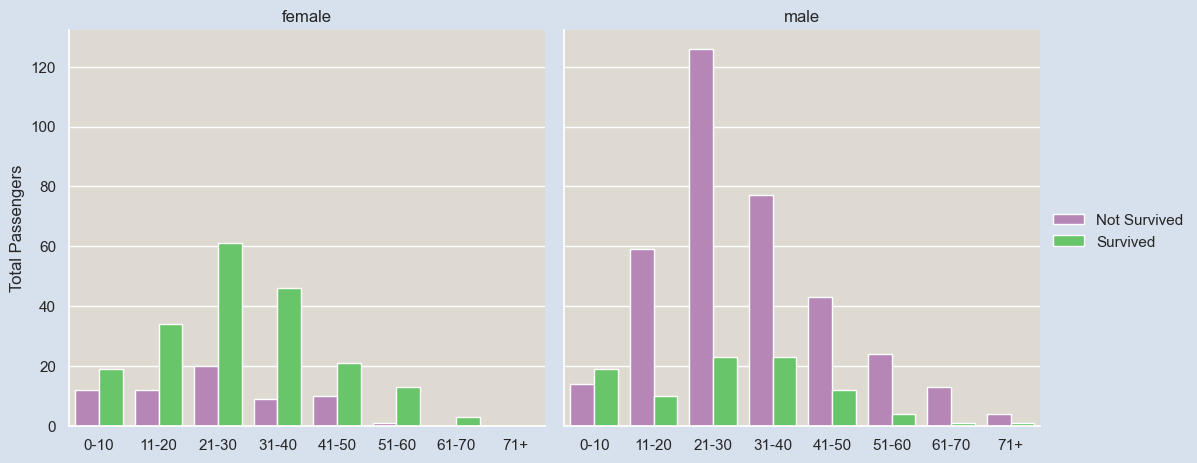

In [26]:
# The relationship between gender and age for the chance of survival
df_gender_age = df_train.groupby(['Sex', 'AgeGroup', 'Survived']).size().reset_index()
df_gender_age.rename(columns={0: 'Count'}, inplace=True)

g = sns.catplot(data=df_gender_age, x='AgeGroup', y='Count', hue='Survived', col='Sex', kind='bar', palette=["#bd7ebe", "#5ad45a"], height=5, aspect=1)
g.set_axis_labels("", "Total Passengers")
g.set_titles("{col_name}")
g.legend.set_visible(False)
mapping = {'0': 'Not Survived', '1': 'Survived'}
legend_data = {mapping[k]: v for k,v in g._legend_data.items()}
g.add_legend(legend_data=legend_data, title='', label_order=list(legend_data))

plt.show()

##### Summary
-   There were approximately twice as many male passengers as female passengers onboard.
-   Female passengers over 50 years old had the chance to survive. Conversely, nearly all male passengers over 60 years old did not survive.
-   Among passengers aged between 11 and 40 years old, the survival rate for females was significant more than double compared to males.
-   The survival rate for children aged below 10, regardless gender, was nearly identical.

##### - Feature 'Embarked'

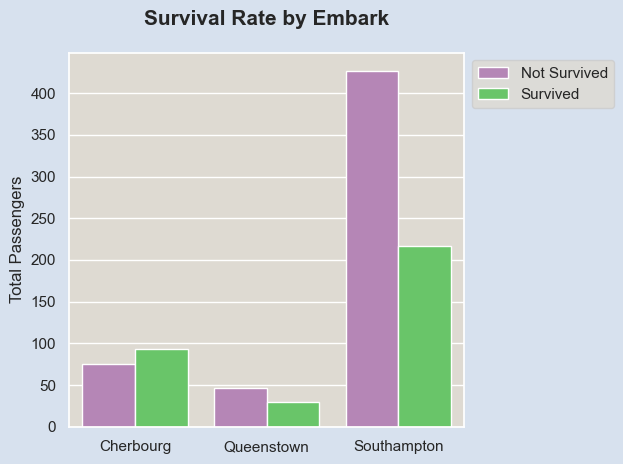

In [27]:
# Group Embarked and Survived features
df_embark = df_train.groupby(['Embarked', 'Survived']).size().reset_index()
df_embark.rename(columns={0: 'Count'}, inplace=True)

# Create barplot using Seaborn
ax = sns.barplot(data=df_embark, x='Embarked', y='Count', hue='Survived', palette=["#bd7ebe", "#5ad45a"])
plt.title('Survival Rate by Embark', fontsize=15, fontweight='bold', pad=20)
labels_barplot = ['Not Survived', 'Survived']
h, l = ax.get_legend_handles_labels()
ax.legend(h, labels_barplot, title='', loc='upper right')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xticklabels(['Cherbourg', 'Queenstown', 'Southampton'])
plt.xlabel('')
plt.ylabel('Total Passengers')
plt.tight_layout()

##### Summary
-   There were three embarked location where the passengers mounted from - Cherbourg, Queenstown and Southampton.
-   Most of passengers embarked from Southampton. The chance of survival for passengers embarked from Cherbourg was higher than people who embarked from Queenstown and Southampton.

### EDA Summary
- Class 3 had the highest number of passengers and mortality rate; Class 1 had the highest survival rate.
- Passengers traveling with 1-3 parents/children had higher survival chances, while traveling alone or with many family members reduced survival rates.
- Higher fares were strongly associated with increased survival rates.
- Children under 10 and adults aged 21-30 had higher survival rates; survival significantly decreased for those over 60.
- Females had significantly higher survival rates than males, particularly those aged 11-40.
- Passengers embarking from Cherbourg had the highest survival rates, while most passengers boarded at Southampton.

## 3. Data Processing

#### 3.1 Process the training dataset

There are a lot of NULL values in the Cabin column, so we decided to drop this column.

In [28]:
train = train.drop("Cabin")

Check NULL values for the Embarked column in the train dataset

In [29]:
train.where(f.col("Embarked").isNull()).show()

+-----------+--------+------+--------------------+------+----+-----+-----+------+----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|Ticket|Fare|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+------+----+--------+
|         62|       1|     1| Icard, Miss. Amelie|female|38.0|    0|    0|113572|80.0|    NULL|
|        830|       1|     1|Stone, Mrs. Georg...|female|62.0|    0|    0|113572|80.0|    NULL|
+-----------+--------+------+--------------------+------+----+-----+-----+------+----+--------+



Find the most frequent value for the Embarked column in the train dataset

In [30]:
train.groupBy("Embarked").count().show()

+--------+-----+
|Embarked|count|
+--------+-----+
|       Q|   77|
|    NULL|    2|
|       C|  168|
|       S|  644|
+--------+-----+



Replace the NULL value in the Embarked column with the most frequent value

In [31]:
train = train.na.fill("S", subset=["Embarked"])

Find the title in the Name column

In [32]:
train = train.withColumn("Title", f.regexp_extract(f.col("Name"), "([A-Za-z]+)\.", 1))
train.groupBy("Title").count().show()

+--------+-----+
|   Title|count|
+--------+-----+
|     Don|    1|
|    Miss|  182|
|Countess|    1|
|     Col|    2|
|     Rev|    6|
|    Lady|    1|
|  Master|   40|
|     Mme|    1|
|    Capt|    1|
|      Mr|  517|
|      Dr|    7|
|     Mrs|  125|
|     Sir|    1|
|Jonkheer|    1|
|    Mlle|    2|
|   Major|    2|
|      Ms|    1|
+--------+-----+



Check each Title to find the appropriate Title for replacing

In [33]:
# Check 'Don' title in the dataset -> will change to 'Mr'
train.where(f.col("Title") == 'Don').show()

+-----------+--------+------+--------------------+----+----+-----+-----+--------+-------+--------+-----+
|PassengerId|Survived|Pclass|                Name| Sex| Age|SibSp|Parch|  Ticket|   Fare|Embarked|Title|
+-----------+--------+------+--------------------+----+----+-----+-----+--------+-------+--------+-----+
|         31|       0|     1|Uruchurtu, Don. M...|male|40.0|    0|    0|PC 17601|27.7208|       C|  Don|
+-----------+--------+------+--------------------+----+----+-----+-----+--------+-------+--------+-----+



In [34]:
# Check 'Countess' title in the dataset -> will change to 'Ms'
train.where(f.col("Title") == 'Countess').show()

+-----------+--------+------+--------------------+------+----+-----+-----+------+----+--------+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|Ticket|Fare|Embarked|   Title|
+-----------+--------+------+--------------------+------+----+-----+-----+------+----+--------+--------+
|        760|       1|     1|Rothes, the Count...|female|33.0|    0|    0|110152|86.5|       S|Countess|
+-----------+--------+------+--------------------+------+----+-----+-----+------+----+--------+--------+



In [35]:
# Check 'Col' title in the dataset -> will change to 'Mr'
train.where(f.col("Title") == 'Col').show()

+-----------+--------+------+--------------------+----+----+-----+-----+------+-----+--------+-----+
|PassengerId|Survived|Pclass|                Name| Sex| Age|SibSp|Parch|Ticket| Fare|Embarked|Title|
+-----------+--------+------+--------------------+----+----+-----+-----+------+-----+--------+-----+
|        648|       1|     1|Simonius-Blumer, ...|male|56.0|    0|    0| 13213| 35.5|       C|  Col|
|        695|       0|     1|     Weir, Col. John|male|60.0|    0|    0|113800|26.55|       S|  Col|
+-----------+--------+------+--------------------+----+----+-----+-----+------+-----+--------+-----+



In [36]:
# Check 'Rev' title in the dataset -> will change to 'Mr'
train.where(f.col("Title") == 'Rev').show()

+-----------+--------+------+--------------------+----+----+-----+-----+-----------+------+--------+-----+
|PassengerId|Survived|Pclass|                Name| Sex| Age|SibSp|Parch|     Ticket|  Fare|Embarked|Title|
+-----------+--------+------+--------------------+----+----+-----+-----+-----------+------+--------+-----+
|        150|       0|     2|Byles, Rev. Thoma...|male|42.0|    0|    0|     244310|  13.0|       S|  Rev|
|        151|       0|     2|Bateman, Rev. Rob...|male|51.0|    0|    0|S.O.P. 1166|12.525|       S|  Rev|
|        250|       0|     2|Carter, Rev. Erne...|male|54.0|    1|    0|     244252|  26.0|       S|  Rev|
|        627|       0|     2|Kirkland, Rev. Ch...|male|57.0|    0|    0|     219533| 12.35|       Q|  Rev|
|        849|       0|     2|   Harper, Rev. John|male|28.0|    0|    1|     248727|  33.0|       S|  Rev|
|        887|       0|     2|Montvila, Rev. Ju...|male|27.0|    0|    0|     211536|  13.0|       S|  Rev|
+-----------+--------+------+--------

In [37]:
# Check 'Mme' title in the dataset -> will change to 'Ms'
train.where(f.col("Title") == 'Mme').show()

+-----------+--------+------+--------------------+------+----+-----+-----+--------+----+--------+-----+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|  Ticket|Fare|Embarked|Title|
+-----------+--------+------+--------------------+------+----+-----+-----+--------+----+--------+-----+
|        370|       1|     1|Aubart, Mme. Leon...|female|24.0|    0|    0|PC 17477|69.3|       C|  Mme|
+-----------+--------+------+--------------------+------+----+-----+-----+--------+----+--------+-----+



In [38]:
# Check 'Capt' title in the dataset -> will change to 'Mr'
train.where(f.col("Title") == 'Capt').show()

+-----------+--------+------+--------------------+----+----+-----+-----+---------+----+--------+-----+
|PassengerId|Survived|Pclass|                Name| Sex| Age|SibSp|Parch|   Ticket|Fare|Embarked|Title|
+-----------+--------+------+--------------------+----+----+-----+-----+---------+----+--------+-----+
|        746|       0|     1|Crosby, Capt. Edw...|male|70.0|    1|    1|WE/P 5735|71.0|       S| Capt|
+-----------+--------+------+--------------------+----+----+-----+-----+---------+----+--------+-----+



In [39]:
# Check 'Jonkheer' title in the dataset -> will change to 'Mr'
train.where(f.col("Title") == 'Jonkheer').show()

+-----------+--------+------+--------------------+----+----+-----+-----+------+----+--------+--------+
|PassengerId|Survived|Pclass|                Name| Sex| Age|SibSp|Parch|Ticket|Fare|Embarked|   Title|
+-----------+--------+------+--------------------+----+----+-----+-----+------+----+--------+--------+
|        823|       0|     1|Reuchlin, Jonkhee...|male|38.0|    0|    0| 19972| 0.0|       S|Jonkheer|
+-----------+--------+------+--------------------+----+----+-----+-----+------+----+--------+--------+



In [40]:
# Check 'Mlle' title in the dataset -> will change to 'Ms'
train.where(f.col("Title") == 'Mlle').show()

+-----------+--------+------+--------------------+------+----+-----+-----+--------+-------+--------+-----+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|  Ticket|   Fare|Embarked|Title|
+-----------+--------+------+--------------------+------+----+-----+-----+--------+-------+--------+-----+
|        642|       1|     1|Sagesser, Mlle. Emma|female|24.0|    0|    0|PC 17477|   69.3|       C| Mlle|
|        711|       1|     1|"Mayne, Mlle. Ber...|female|24.0|    0|    0|PC 17482|49.5042|       C| Mlle|
+-----------+--------+------+--------------------+------+----+-----+-----+--------+-------+--------+-----+



In [41]:
# Check 'Major' title in the dataset -> will change to 'Mr'
train.where(f.col("Title") == 'Major').show()

+-----------+--------+------+--------------------+----+----+-----+-----+------+-----+--------+-----+
|PassengerId|Survived|Pclass|                Name| Sex| Age|SibSp|Parch|Ticket| Fare|Embarked|Title|
+-----------+--------+------+--------------------+----+----+-----+-----+------+-----+--------+-----+
|        450|       1|     1|Peuchen, Major. A...|male|52.0|    0|    0|113786| 30.5|       S|Major|
|        537|       0|     1|Butt, Major. Arch...|male|45.0|    0|    0|113050|26.55|       S|Major|
+-----------+--------+------+--------------------+----+----+-----+-----+------+-----+--------+-----+



Replace misspelling title values

In [42]:
train = train.replace(["Don", "Countess", "Col", "Rev", "Mme", "Capt", "Jonkheer", "Mlle", "Major", "Sir", "Lady"], 
                      ["Mr", "Ms", "Mr", "Mr", "Ms", "Mr", "Mr", "Ms", "Mr", "Mr", "Ms"], 
                      "Title")
train.groupBy("Title").count().show()

+------+-----+
| Title|count|
+------+-----+
|  Miss|  182|
|Master|   40|
|    Mr|  531|
|    Dr|    7|
|   Mrs|  125|
|    Ms|    6|
+------+-----+



Check the Title values to make sure matching with the Sex values

In [43]:
train.groupBy(["Title", "Sex"]).count().show()

+------+------+-----+
| Title|   Sex|count|
+------+------+-----+
|Master|  male|   40|
|    Dr|  male|    6|
|   Mrs|female|  125|
|  Miss|female|  182|
|    Mr|  male|  531|
|    Dr|female|    1|
|    Ms|female|    6|
+------+------+-----+



Calculate the average age for each title

In [44]:
avg_age_df = spark.createDataFrame(train.groupBy(["Title"]).agg(f.avg("Age").alias("Avg_Age")).toPandas())
avg_age_df = avg_age_df.withColumn("Avg_Age", f.round(avg_age_df["Avg_Age"]).cast("double"))
avg_age_df.show()

+------+-------+
| Title|Avg_Age|
+------+-------+
|  Miss|   22.0|
|Master|    5.0|
|    Mr|   33.0|
|    Dr|   42.0|
|   Mrs|   36.0|
|    Ms|   30.0|
+------+-------+



Replace the missing values in the Age column with the average values for each Title

In [45]:
for row in avg_age_df.collect():
    train = train.withColumn("Age", f.when((f.col("Title") == row["Title"]) & (f.col("Age").isNull()), row["Avg_Age"]).otherwise(f.col("Age")))

Check missing values again in the train dataset

In [46]:
train.select([f.count(f.when(f.isnan(c) | f.col(c).isNull(), c)).alias(c) for c in train.columns]).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,0,0,0,0,0,0,0,0,0,0,0,0


Remove unnecessary columns for the analysis

In [47]:
train = train.drop("PassengerId", "Name", "Ticket", "Title")
train.show(5)

+--------+------+------+----+-----+-----+-------+--------+
|Survived|Pclass|   Sex| Age|SibSp|Parch|   Fare|Embarked|
+--------+------+------+----+-----+-----+-------+--------+
|       0|     3|  male|22.0|    1|    0|   7.25|       S|
|       1|     1|female|38.0|    1|    0|71.2833|       C|
|       1|     3|female|26.0|    0|    0|  7.925|       S|
|       1|     1|female|35.0|    1|    0|   53.1|       S|
|       0|     3|  male|35.0|    0|    0|   8.05|       S|
+--------+------+------+----+-----+-----+-------+--------+
only showing top 5 rows



#### Summary
- Remove Cabin feature due to a lot of missing values.
- Replace missing values in the Embarked column with the most frequent value (S).
- Create Title column based on Name column and modify the misspelling for this column.
- Replace the missing values in Age colum with the average age of each Title category.

#### 3.2 Process for the test dataset

Remove the Cabin column due to lots of missing values

In [48]:
test = test.drop("Cabin")
test.show(5)

+-----------+------+--------------------+------+----+-----+-----+-------+-------+--------+
|PassengerId|Pclass|                Name|   Sex| Age|SibSp|Parch| Ticket|   Fare|Embarked|
+-----------+------+--------------------+------+----+-----+-----+-------+-------+--------+
|        892|     3|    Kelly, Mr. James|  male|34.5|    0|    0| 330911| 7.8292|       Q|
|        893|     3|Wilkes, Mrs. Jame...|female|47.0|    1|    0| 363272|    7.0|       S|
|        894|     2|Myles, Mr. Thomas...|  male|62.0|    0|    0| 240276| 9.6875|       Q|
|        895|     3|    Wirz, Mr. Albert|  male|27.0|    0|    0| 315154| 8.6625|       S|
|        896|     3|Hirvonen, Mrs. Al...|female|22.0|    1|    1|3101298|12.2875|       S|
+-----------+------+--------------------+------+----+-----+-----+-------+-------+--------+
only showing top 5 rows



Check the row with NULL value in the Fare column for the test dataset

In [49]:
test.where(f.col("Fare").isNull()).show()

+-----------+------+------------------+----+----+-----+-----+------+----+--------+
|PassengerId|Pclass|              Name| Sex| Age|SibSp|Parch|Ticket|Fare|Embarked|
+-----------+------+------------------+----+----+-----+-----+------+----+--------+
|       1044|     3|Storey, Mr. Thomas|male|60.5|    0|    0|  3701|NULL|       S|
+-----------+------+------------------+----+----+-----+-----+------+----+--------+



Replace the NULL value in the Fare column with the average value for Pclass=3, Sex=male, and Embarked=S for the test dataset

In [50]:
avg_fare = test.filter("Pclass=3 and Sex='male' and Embarked='S'").agg({"Fare": "avg"}).collect()[0][0]
test = test.na.fill(avg_fare, subset=["Fare"])

Check no missing value in the Fare column

In [51]:
test.where(f.col("Fare").isNull()).show()

+-----------+------+----+---+---+-----+-----+------+----+--------+
|PassengerId|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Embarked|
+-----------+------+----+---+---+-----+-----+------+----+--------+
+-----------+------+----+---+---+-----+-----+------+----+--------+



Find the title in the Name column

In [52]:
test = test.withColumn("Title", f.regexp_extract(f.col("Name"), "([A-Za-z]+)\.", 1))
test.groupBy("Title").count().show()

+------+-----+
| Title|count|
+------+-----+
|  Dona|    1|
|  Miss|   78|
|   Col|    2|
|   Rev|    2|
|Master|   21|
|    Mr|  240|
|    Dr|    1|
|   Mrs|   72|
|    Ms|    1|
+------+-----+



In [53]:
# Check 'Dona' title in the dataset -> will change to 'Ms'
test.where(f.col("Title") == 'Dona').show()

+-----------+------+--------------------+------+----+-----+-----+--------+-----+--------+-----+
|PassengerId|Pclass|                Name|   Sex| Age|SibSp|Parch|  Ticket| Fare|Embarked|Title|
+-----------+------+--------------------+------+----+-----+-----+--------+-----+--------+-----+
|       1306|     1|Oliva y Ocana, Do...|female|39.0|    0|    0|PC 17758|108.9|       C| Dona|
+-----------+------+--------------------+------+----+-----+-----+--------+-----+--------+-----+



In [54]:
# Check 'Col' title in the dataset -> will change to 'Mr'
test.where(f.col("Title") == 'Col').show()

+-----------+------+--------------------+----+----+-----+-----+--------+-------+--------+-----+
|PassengerId|Pclass|                Name| Sex| Age|SibSp|Parch|  Ticket|   Fare|Embarked|Title|
+-----------+------+--------------------+----+----+-----+-----+--------+-------+--------+-----+
|       1023|     1|Gracie, Col. Arch...|male|53.0|    0|    0|  113780|   28.5|       C|  Col|
|       1094|     1|Astor, Col. John ...|male|47.0|    1|    0|PC 17757|227.525|       C|  Col|
+-----------+------+--------------------+----+----+-----+-----+--------+-------+--------+-----+



In [55]:
# Check 'Rev' title in the dataset -> will change to 'Mr'
test.where(f.col("Title") == 'Rev').show()

+-----------+------+--------------------+----+----+-----+-----+------+----+--------+-----+
|PassengerId|Pclass|                Name| Sex| Age|SibSp|Parch|Ticket|Fare|Embarked|Title|
+-----------+------+--------------------+----+----+-----+-----+------+----+--------+-----+
|       1041|     2|Lahtinen, Rev. Wi...|male|30.0|    1|    1|250651|26.0|       S|  Rev|
|       1056|     2|Peruschitz, Rev. ...|male|41.0|    0|    0|237393|13.0|       S|  Rev|
+-----------+------+--------------------+----+----+-----+-----+------+----+--------+-----+



In [59]:
# Check 'Dr' title in the dataset -> will change to 'Mr'
test.where(f.col("Title") == 'Dr').show()

+-----------+------+--------------------+----+----+-----+-----+------+-------+--------+-----+
|PassengerId|Pclass|                Name| Sex| Age|SibSp|Parch|Ticket|   Fare|Embarked|Title|
+-----------+------+--------------------+----+----+-----+-----+------+-------+--------+-----+
|       1185|     1|Dodge, Dr. Washin...|male|53.0|    1|    1| 33638|81.8583|       S|   Dr|
+-----------+------+--------------------+----+----+-----+-----+------+-------+--------+-----+



Replace misspelling title values

In [60]:
test = test.replace(["Dona", "Col", "Rev", "Dr"], 
                    ["Ms", "Mr", "Mr", "Mr"], 
                    "Title")
test.groupBy("Title").count().show()

+------+-----+
| Title|count|
+------+-----+
|  Miss|   78|
|Master|   21|
|    Mr|  245|
|   Mrs|   72|
|    Ms|    2|
+------+-----+



Check the Title values to make sure matching the the Sex values

In [61]:
test.groupBy(["Title", "Sex"]).count().show()

+------+------+-----+
| Title|   Sex|count|
+------+------+-----+
|Master|  male|   21|
|   Mrs|female|   72|
|  Miss|female|   78|
|    Mr|  male|  245|
|    Ms|female|    2|
+------+------+-----+



Calculate the average age values for each title

In [62]:
avg_age_df_test = spark.createDataFrame(test.groupBy(["Title"]).agg(f.avg("Age").alias("Avg_Age")).toPandas())
avg_age_df_test = avg_age_df_test.withColumn("Avg_Age", f.round(avg_age_df_test["Avg_Age"]).cast("double"))
avg_age_df_test.show()

+------+-------+
| Title|Avg_Age|
+------+-------+
|  Miss|   22.0|
|Master|    7.0|
|    Mr|   32.0|
|   Mrs|   39.0|
|    Ms|   39.0|
+------+-------+



Replace the NULL values in the Age column with the average age for each title

In [63]:
for row in avg_age_df_test.collect():
    test = test.withColumn("Age", f.when((f.col("Title") == row["Title"]) & (f.col("Age").isNull()), row["Avg_Age"]).otherwise(f.col("Age")))

Check NULL values in the test dataset

In [64]:
test.select([f.count(f.when(f.isnan(c) | f.col(c).isNull(), c)).alias(c) for c in test.columns]).toPandas()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Title
0,0,0,0,0,0,0,0,0,0,0,0


Remove unnecessary columns for the analysis

In [65]:
test = test.drop("PassengerId", "Name", "Ticket", "Title")
test.show(5)

+------+------+----+-----+-----+-------+--------+
|Pclass|   Sex| Age|SibSp|Parch|   Fare|Embarked|
+------+------+----+-----+-----+-------+--------+
|     3|  male|34.5|    0|    0| 7.8292|       Q|
|     3|female|47.0|    1|    0|    7.0|       S|
|     2|  male|62.0|    0|    0| 9.6875|       Q|
|     3|  male|27.0|    0|    0| 8.6625|       S|
|     3|female|22.0|    1|    1|12.2875|       S|
+------+------+----+-----+-----+-------+--------+
only showing top 5 rows



#### Summary
- Remove Cabin feature due to a lot of missing values.
- Replace missing values in the Fare column with the average value of Pclass=3, Sex=male, and Embarked=S.
- Create Title column based on Name column and modify the misspelling for this column.
- Replace the missing values in Age colum with the average age of each Title category.

## 4. Feature Selection

To reduce multicollinearity, it is crucial to make sure that features don't have extreme values. The extreme values often lead to strong correlations among the features, which can potentially compromise the reliability of the results obtained from the predictive model.

In [66]:
# Use LabelEncoder to convert features 'Sex' and 'Embarked' to numerical features
df_train['SexLbl'] = LabelEncoder().fit_transform(df_train['Sex'])
df_train['EmbarkedLbl'] = LabelEncoder().fit_transform(df_train['Embarked'])

df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeGroup,SexLbl,EmbarkedLbl
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S,21-30,1,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,31-40,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S,21-30,0,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,31-40,0,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S,31-40,1,2


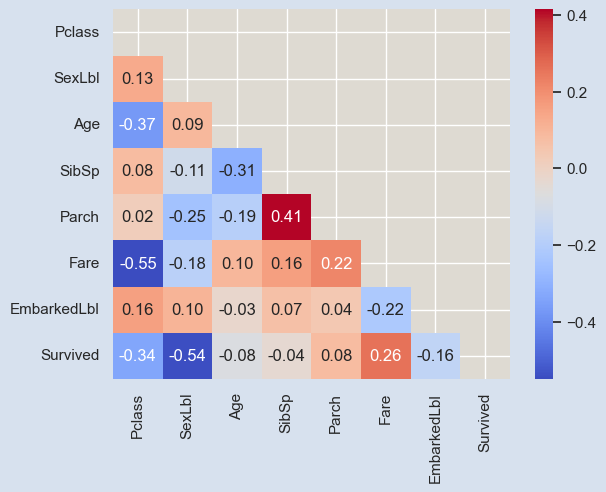

In [67]:
# Create correlation matrix for all variables
features_lst = ['Pclass', 'SexLbl', 'Age', 'SibSp', 'Parch', 'Fare', 'EmbarkedLbl', 'Survived']
mask = np.triu(np.ones_like(df_train[features_lst].corr(), dtype=np.bool_))
sns.heatmap(data=df_train[features_lst].corr(), annot=True, fmt=".2f", mask=mask, cmap='coolwarm')

plt.show()

##### Summary
-   Based on the correlation matrix above, it didn't contain any strong correlations among the features. 'Parch' and 'SibSp' had the highest correlation coefficient at 0.41. However, it still wasn't the extreme values. 
-   The feature 'Survived' was most correlated with feature 'Fare' with the value at 0.26. It means that the passengers paid more for the tickets, they were more likely to survive. All features will be included in the predictive model.

## 5. Predictive Models

#### 5.1 Encoding features

Categorical data presents a challenge as most algorithms are engineered to process numerical data exclusively. Hence, categorical features necessitate encoding into numerical values prior to their utilisation as inputs for machine learning algorithms.

Features 'Sex', 'Embarked' will be encoded into numbers

In [68]:
encode_list = ['Sex', 'Embarked']
sindexer = StringIndexer(inputCols = encode_list, outputCols = [f"{col}_index" for col in encode_list])

Dummy numerised strings into a sparse vector

In [69]:
ohencoder = OneHotEncoder(inputCols=[f"{col}_index" for col in encode_list], outputCols=[f"{col}_onehot" for col in encode_list])

Combine all input features into a single vector called 'features'

In [70]:
input_list = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'] + [f"{col}_onehot" for col in encode_list]
assemblers = VectorAssembler(inputCols=input_list, outputCol="features")

#### 5.2 Split dataset

Split the training data into 2 parts: train and test datasets, which will allow us to evaluate the performance of models.

In [71]:
model_df_train, model_df_test = train.randomSplit([0.8, 0.2])

In [72]:
model_df_train.groupby('Survived').count().show()

+--------+-----+
|Survived|count|
+--------+-----+
|       1|  275|
|       0|  432|
+--------+-----+



In [73]:
model_df_test.groupby('Survived').count().show()

+--------+-----+
|Survived|count|
+--------+-----+
|       1|   67|
|       0|  117|
+--------+-----+



#### 5.3 Fit and transform the Models

##### - Random Forest Classifier

The Random Forest algorithm is made up of a collection of Decision Trees. Each tree in this group is built using the data sample drawn from a training set with replacement, which is called the bootstrap sample. Within this training sample, one-third is kept aside as test data, known as the out-of-bag sample. Another instance of randomness is injected through feature bagging, which adds diversity to the dataset and reduces correlation among Decision Trees. For classification task, the predicted class is determined by a majority vote, which is the most frequent categorical variable. Finally, the out-of-bag sample is then used for cross-validation, finalising the prediction.

In [74]:
# Create hyper parameters
rf_classifier = RandomForestClassifier(labelCol='Survived', featuresCol='features')
rf_paramGrid = (ParamGridBuilder()
                .addGrid(rf_classifier.maxDepth, [5, 10, 20])
                .addGrid(rf_classifier.maxBins, [20, 32, 50])
                .addGrid(rf_classifier.numTrees, [20, 50, 75])
                .addGrid(rf_classifier.impurity, ["gini", "entropy"])
                .addGrid(rf_classifier.minInstancesPerNode, [1, 5, 10])
                .build())

# Create pipeline for Random Forest Classifier               
rf_pipeline = Pipeline(stages=[sindexer, ohencoder, assemblers, rf_classifier])

In [ ]:
# Fit and transform the model
crossval = CrossValidator(estimator=rf_pipeline,
                              estimatorParamMaps=rf_paramGrid,
                              evaluator=MulticlassClassificationEvaluator(labelCol='Survived'),
                              numFolds=3)
rf_model = crossval.fit(model_df_train)
rf_prediction = rf_model.transform(model_df_test)

In [ ]:
# Save the Random Forest Classifier Model and the Prediction
rf_model.save("./models/random_forest_model")
rf_prediction.write.mode("overwrite").option("header","true").format("parquet").save("./data_predictions/random_forest_prediction")

In [75]:
# Load the Model and the Prediction
rf_model = CrossValidatorModel.load("./models/random_forest_model")
rf_prediction = spark.read.parquet("./data_predictions/random_forest_prediction")

##### - Gradient Boosted Tree Classifier

Gradient boosting is a type of machine learning ensemble method that works by combining the predictions of several weak learners, usually decision trees, in a sequence. Its objective is to enhance predictive accuracy by adjusting the model’s weights using the errors from previous rounds, which leads to a gradual reduction in prediction errors and improved overall model accuracy. The fundamental concept behind boosting algorithms involves creating an initial model on the training dataset and then constructing subsequent models to correct errors made by the preceding ones.

In [76]:
# Create hyper parameters
gbt_classifier = GBTClassifier(labelCol="Survived", featuresCol='features')
gbt_paramGrid = (ParamGridBuilder()
                .addGrid(gbt_classifier.maxDepth, [5, 10, 20])
                .addGrid(gbt_classifier.maxBins, [20, 32, 50])
                .addGrid(gbt_classifier.maxIter, [10, 20, 30])
                .addGrid(gbt_classifier.minInstancesPerNode, [1, 5, 10])
                .build())
    
# Create a Pipeline for the Gradient Boosted Classifier
gbt_pipeline = Pipeline(stages=[sindexer, ohencoder, assemblers, gbt_classifier])

In [ ]:
# Fit and transform the model
tvs = TrainValidationSplit(estimator=gbt_pipeline, 
                           estimatorParamMaps=gbt_paramGrid,
                           evaluator=MulticlassClassificationEvaluator(labelCol='Survived'),
                           trainRatio=0.8)
gbt_model = tvs.fit(model_df_train)
gbt_prediction = gbt_model.transform(model_df_test)

In [ ]:
# Save the Random Forest Classifier Model and the Prediction
gbt_model.save("./models/gradient_boosted_model")
gbt_prediction.write.mode("overwrite")\
            .option("header","true").format("parquet").save("./data_predictions/gradient_boosted_prediction")

In [77]:
# Load the Model and the Prediction
gbt_model = TrainValidationSplitModel.load("./models/gradient_boosted_model")
gbt_prediction = spark.read.parquet("./data_predictions/gradient_boosted_prediction")

##### - Logistic Regression

Logistic regression is a statistical technique employed in machine learning to construct models when the dependent variable is binary, meaning it has two possible outcomes. It is utilised to characterise data and elucidate the association between a single dependent binary variable and one or more independent variables that can be nominal, ordinal, interval, or ratio-level.

In [78]:
# Create the hyper parameter
lr = LogisticRegression(labelCol="Survived", featuresCol='features')
lr_paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())

# Create a Pipeline for the Gradient Boosted Classifier
lr_pipeline = Pipeline(stages=[sindexer, ohencoder, assemblers, lr])

In [ ]:
crossval = CrossValidator(estimator=lr_pipeline,
                            estimatorParamMaps=lr_paramGrid,
                            evaluator=MulticlassClassificationEvaluator(labelCol='Survived'),
                            numFolds=3)
lr_model = crossval.fit(model_df_train)
lr_prediction = lr_model.transform(model_df_test)

In [ ]:
# Save the Logistic Regression Model and the Prediction
lr_model.save("./models/logistic_regression_model")
lr_prediction.write.mode("overwrite")\
            .option("header","true").format("parquet").save("./data_predictions/logistic_regression_prediction")

In [79]:
# Load the Model and the Prediction
lr_model = CrossValidatorModel.load("./models/logistic_regression_model")
lr_prediction = spark.read.parquet("./data_predictions/logistic_regression_prediction")

## 6. Models Comparison

After obtaining the models, the next step involves predicting labels for the test dataset (which is splitted from the training data). One important tool for evaluating how well a classification model performs is the confusion matrix. This matrix breaks down predictions and compares them to the actual target values. It includes entries for true positives, true negatives, false positives, and false negatives, providing valuable insights into the model's performance, identifying misclassifications, and improving predictive accuracy. To elucidate the rationale behind the selection of the optimal model, comprehensive performance metrics are considered.

In [81]:
# Create a confusion matrix
def create_cf_matrix(prediction):
    y_true = prediction.select(['Survived']).collect()
    y_pred = prediction.select(['prediction']).collect()
    cf_matrix = confusion_matrix(y_true, y_pred)
    return cf_matrix

In [82]:
# Create labels for the confussion matrix
def create_labels(cf_matrix, group_names):
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    return labels

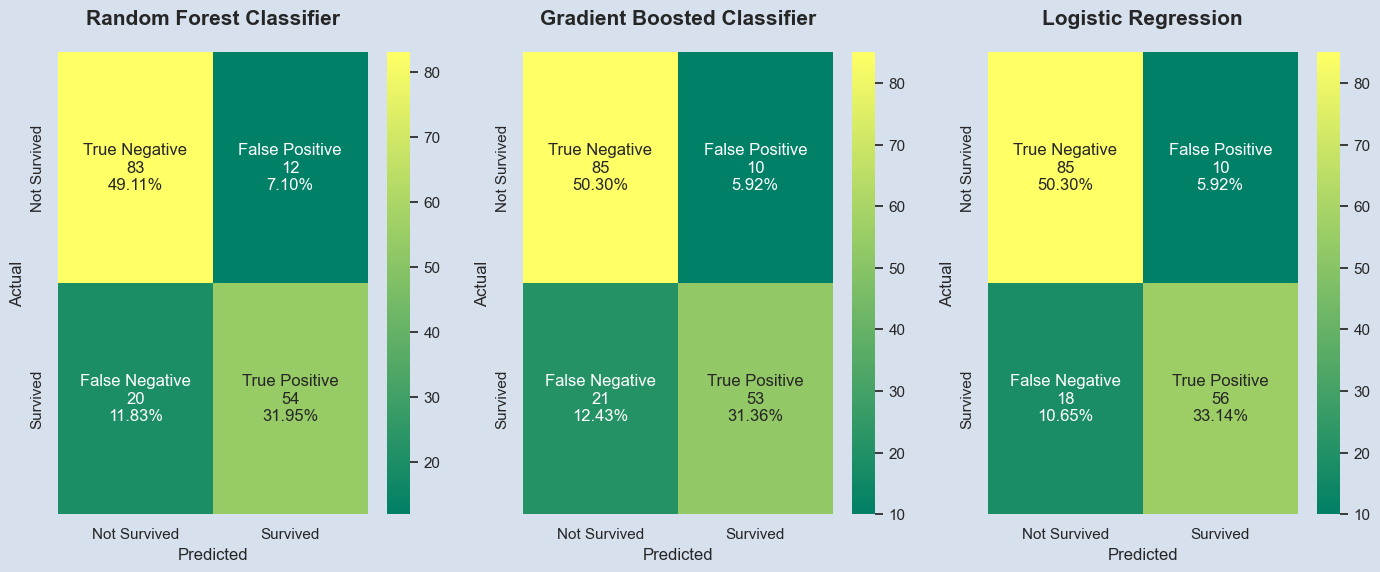

In [83]:
# Show the confusion matrix for each model
classes = ['Not Survived', 'Survived']
group_names = ['True Negative','False Positive','False Negative','True Positive']

plt.figure(figsize=(17, 6))
plt.subplot(1, 3, 1)
rf_matrix = create_cf_matrix(rf_prediction)
labels = create_labels(rf_matrix, group_names)
sns.heatmap(rf_matrix, annot=labels, cmap="summer", xticklabels=classes, yticklabels=classes, fmt='')
plt.title('Random Forest Classifier', fontsize=15, fontweight='bold', pad=20)
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 3, 2)
gbt_matrix = create_cf_matrix(gbt_prediction)
labels = create_labels(gbt_matrix, group_names)
sns.heatmap(gbt_matrix, annot=labels, cmap="summer", xticklabels=classes, yticklabels=classes, fmt='')
plt.title('Gradient Boosted Classifier', fontsize=15, fontweight='bold', pad=20)
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 3, 3)
lr_matrix = create_cf_matrix(lr_prediction)
labels = create_labels(lr_matrix, group_names)
sns.heatmap(lr_matrix, annot=labels, cmap="summer", xticklabels=classes, yticklabels=classes, fmt='')
plt.title('Logistic Regression', fontsize=15, fontweight='bold', pad=20)
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()

In [ ]:
# Create the performance dataframe to store the performance of each model
performance_df = pd.DataFrame(columns=['Performance', 'Random Forest Classifier', 'Gradient Boosted Classifier', 'Logistic Regression'])
performance_df['Performance'] = ['Accuracy', 'Precision', 'Recall', 'F1']

# Score the Random Forest Classifier Model
performance_df['Random Forest Classifier'] = [round(MulticlassClassificationEvaluator(labelCol='Survived',metricName='accuracy').evaluate(rf_prediction), 3),
                                            round(MulticlassClassificationEvaluator(labelCol='Survived',metricName='weightedPrecision').evaluate(rf_prediction), 3),
                                            round(MulticlassClassificationEvaluator(labelCol='Survived',metricName='weightedRecall').evaluate(rf_prediction), 3),
                                            round(MulticlassClassificationEvaluator(labelCol='Survived',metricName='f1').evaluate(rf_prediction), 3)]

# Score the Gradient Boosted Classifier Model
performance_df['Gradient Boosted Classifier'] = [round(MulticlassClassificationEvaluator(labelCol='Survived',metricName='accuracy').evaluate(gbt_prediction), 3),
                                            round(MulticlassClassificationEvaluator(labelCol='Survived',metricName='weightedPrecision').evaluate(gbt_prediction), 3),
                                            round(MulticlassClassificationEvaluator(labelCol='Survived',metricName='weightedRecall').evaluate(gbt_prediction), 3),
                                            round(MulticlassClassificationEvaluator(labelCol='Survived',metricName='f1').evaluate(gbt_prediction), 3)]

# Score the Logistic Regression Model
performance_df['Logistic Regression'] = [round(MulticlassClassificationEvaluator(labelCol='Survived',metricName='accuracy').evaluate(lr_prediction), 3),
                                            round(MulticlassClassificationEvaluator(labelCol='Survived',metricName='weightedPrecision').evaluate(lr_prediction), 3),
                                            round(MulticlassClassificationEvaluator(labelCol='Survived',metricName='weightedRecall').evaluate(lr_prediction), 3),
                                            round(MulticlassClassificationEvaluator(labelCol='Survived',metricName='f1').evaluate(lr_prediction), 3)]

In [84]:
performance_df

,Performance,Random Forest Classifier,Gradient Boosted Classifier,Logistic Regression
0,Accuracy,0.811,0.817,0.834
1,Precision,0.811,0.819,0.835
2,Recall,0.811,0.817,0.834
3,F1,0.809,0.814,0.833


##### Summary
-   Logistic Regression Model has the highest accuracy at 0.834 following by Gradient Boosted Classifier Model and Random Forest Classifier Model. 
-   Logistic Regression Model and Gradient Boosted Classifier Model have the lowest False Postive values at 10 cases where the Models incorrectly predict the chance of survival. 
-   However, Logistic Regression Model has the highest number of True Positive where the Model correctly predicts the chance of survival.
-   As a result, Logistic Regression Model is the best model to predict the chance of survival for Titanic dataset.

## 7. Apply the best model to the testing data

In [85]:
test_prediction = lr_model.transform(test)

In [86]:
test_prediction.show(5)

+------+------+----+-----+-----+-------+--------+---------+--------------+-------------+---------------+--------------------+--------------------+--------------------+----------+
|Pclass|   Sex| Age|SibSp|Parch|   Fare|Embarked|Sex_index|Embarked_index|   Sex_onehot|Embarked_onehot|            features|       rawPrediction|         probability|prediction|
+------+------+----+-----+-----+-------+--------+---------+--------------+-------------+---------------+--------------------+--------------------+--------------------+----------+
|     3|  male|34.5|    0|    0| 7.8292|       Q|      0.0|           2.0|(1,[0],[1.0])|      (2,[],[])|(8,[0,1,4,5],[3.0...|[2.30382153409529...|[0.90919304263201...|       0.0|
|     3|female|47.0|    1|    0|    7.0|       S|      1.0|           0.0|    (1,[],[])|  (2,[0],[1.0])|[3.0,47.0,1.0,0.0...|[0.70373463694808...|[0.66901526852760...|       0.0|
|     2|  male|62.0|    0|    0| 9.6875|       Q|      0.0|           2.0|(1,[0],[1.0])|      (2,[],[])|(

24/04/22 10:55:44 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/04/22 10:55:44 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


In [87]:
print(f'Number of survived passengers: {test_prediction.filter(f.col("prediction") == 1).count()}')
print(f'Number of not survived passengers: {test_prediction.filter(f.col("prediction") == 0).count()}')

Number of survived passengers: 148
Number of not survived passengers: 270


24/04/22 19:56:51 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1020383 ms exceeds timeout 120000 ms
24/04/22 19:56:51 WARN SparkContext: Killing executors is not supported by current scheduler.
24/04/22 19:56:58 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$

## 8. Conclusion

The correlation matrix indicated no strong correlations among the features, with 'Parch' and 'SibSp' showing the highest correlation coefficient of 0.41, which is not considered extreme. The feature 'Survived' exhibited the highest correlation with 'Fare' at 0.26, suggesting that passengers who paid higher fares were more likely to survive. Consequently, all features were included in the predictive model.

Among the models evaluated, the Logistic Regression Model demonstrated the highest accuracy at 0.834, followed by the Gradient Boosted Classifier and Random Forest Classifier models. Both the Logistic Regression and Gradient Boosted Classifier models had the lowest false positive rates, with only 10 cases of incorrectly predicted survival. Furthermore, the Logistic Regression Model achieved the highest number of true positive predictions.

Thus, the Logistic Regression Model was identified as the most effective for predicting survival on the Titanic dataset. When applied to the testing dataset, this model predicted that 148 passengers survived and 270 did not survive.